In [73]:
import pandas as pd
from sklearn.model_selection import train_test_split

college = pd.read_csv("../../data/College.csv")
college = college.rename({"Unnamed: 0": "College"}, axis=1)
college = college.set_index("College")
college["Private"] = (college["Private"] == "Yes").astype(int)
college['Grad.Rate'] = college['Grad.Rate'].clip(upper=100) # Remove anomalies

college_train, college_test = train_test_split(college,
                                         test_size=0.2,
                                         random_state=0)

Y_train, Y_test = college_train["Outstate"], college_test["Outstate"]

In [74]:
from ISLP.models import Stepwise, sklearn_selected, ModelSpec as MS
import statsmodels.api as sm

predictors = college.columns.drop("Outstate")
design = MS(predictors)
design.fit_transform(college_train)

states = []

for nb_predictors in range(1, len(predictors)):
    strategy = Stepwise.first_peak(design,
                                direction='forward',
                                max_terms=nb_predictors)

    df_selected = sklearn_selected(sm.OLS,
                                strategy)
    df_selected.fit(college_train, Y_train)
    states.append(df_selected.selected_state_)

In [75]:
from sklearn.metrics import mean_squared_error

test_err = []

for state in states:
    X_sel = MS(list(state)).fit_transform(college_train)
    X_pred = MS(list(state)).fit_transform(college_test)

    model = sm.OLS(Y_train, X_sel).fit()
    
    y_pred = model.predict(X_pred)
    mse = mean_squared_error(Y_test, y_pred)
    
    test_err.append(mse)

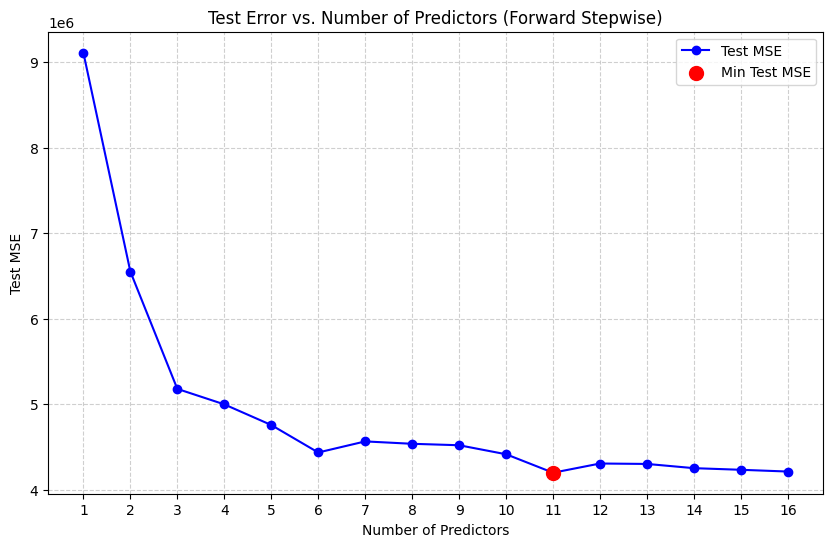

In [76]:
import matplotlib.pyplot as plt
import numpy as np

num_predictors = np.arange(1, len(test_err) + 1)

plt.figure(figsize=(10, 6))
plt.plot(num_predictors, test_err, marker='o', linestyle='-', color='b', label='Test MSE')

min_idx = np.argmin(test_err)
plt.scatter(num_predictors[min_idx], test_err[min_idx], color='r', s=100, zorder=5, label='Min Test MSE')

plt.xlabel("Number of Predictors")
plt.ylabel("Test MSE")
plt.title("Test Error vs. Number of Predictors (Forward Stepwise)")
plt.xticks(num_predictors)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


The trend of test errors shows a rapid decline initially as the first three predictors are added, indicating that these variables capture the most important variation in Outstate. After that, the test error continues to decline more gradually until six predictors, showing moderate improvements. Interestingly, adding the seventh, eighth, and ninth predictors causes the test error to increase slightly, suggesting a brief period of overfitting or adding less informative variables. The test error then decreases again, reaching its lowest point when eleven predictors are included. Beyond this point, adding more predictors leads to a slight increase and eventual stabilization of the test error up to sixteen predictors. Although the absolute lowest test error occurs with eleven predictors, the marginal gains beyond six predictors are small, indicating that a simpler model with fewer predictors could be preferred for interpretability and reduced complexity, while still maintaining near-optimal predictive performance.

In [77]:
from pygam import LinearGAM, s, l

selected_features = list(states[5])
selected_smooth = ['Expend', 'Grad.Rate', 'Room.Board', 'Terminal', 'perc.alumni']
linear_features = ['Private']

features = linear_features + selected_smooth

y = college_train['Outstate'].values

gam = LinearGAM(l(0) + s(1, lam=0.6) + s(2, lam=0.6) + s(3, lam=0.6) + s(4, lam=0.6) + s(5, lam=0.6))
gam.fit(college_train[features], y)

gam.summary()


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      55.989
Link Function:                     IdentityLink Log Likelihood:                                 -9915.5959
Number of Samples:                          621 AIC:                                            19945.1697
                                                AICc:                                           19956.9092
                                                GCV:                                          4088052.0297
                                                Scale:                                        3430458.4584
                                                Pseudo R-Squared:                                   0.8026
Feature Function                  Lam

C:\Users\gumba\AppData\Local\Temp\ipykernel_17988\1400113634.py:14: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [78]:
X_test = college_test[features].values
y_test = college_test['Outstate'].values

y_pred = gam.predict(X_test)

from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test R²: {r2:.3f}")
print(f"Test RMSE: {rmse:.2f}")

Test R²: 0.793
Test RMSE: 1905.49


The GAM fitted using forward-selected features performs quite well on the test set, achieving a Test R² of 0.796, which indicates that approximately 79.6% of the variance in the out-of-state tuition (Outstate) is explained by the selected predictors. The RMSE of 1894.59 suggests that, on average, the predicted tuition deviates from the actual tuition by about $1,895. Given that the model was built using forward selection, these metrics demonstrate that the chosen combination of continuous variables (Expend, Grad.Rate, Room.Board, Terminal, perc.alumni) and the categorical variable (Private) captures most of the important variation in tuition while maintaining reasonable predictive accuracy on unseen data. Overall, this indicates a strong and generalizable model for explaining out-of-state tuition.

In [79]:
from ISLP.transforms import NaturalSpline

def partial_effect(df, target, smooth_vars, linear_vars, study_var, 
                   is_categorical=False, df_spline=4, n_points=100, ax=None):
    """
    Compute and plot the partial effect of a chosen variable (continuous or categorical).
    If ax is provided, plot into that axis instead of making a new figure.
    """
    # --- Step 1: Build spline basis for continuous variables ---
    spline_transforms = {}
    Xs = []
    spline_cols = {}
    for var in smooth_vars:
        ns = NaturalSpline(df=df_spline).fit(df[var].values.reshape(-1,1))
        spline_transforms[var] = ns
        Xt = ns.transform(df[var].values.reshape(-1,1))
        spline_cols[var] = Xt.shape[1]
        Xs.append(Xt)
    
    # --- Step 2: Encode categorical/linear variables ---
    dummies_info = {}
    for var in linear_vars:
        if df[var].dtype == 'object' or df[var].dtype.name == 'category':
            Xt = pd.get_dummies(df[var], drop_first=False).values
            dummies_info[var] = Xt.shape[1]
            Xs.append(Xt)
        else:  # binary or numeric
            if df[var].nunique() == 2:  # treat binary as categorical
                Xt = pd.get_dummies(df[var], drop_first=False).values
                dummies_info[var] = Xt.shape[1]
                Xs.append(Xt)
            else:  # true numeric covariate, not smoothed
                Xt = df[var].values.reshape(-1,1)
                dummies_info[var] = 1
                Xs.append(Xt)
    
    # --- Step 3: Design matrix ---
    X_bh = np.hstack(Xs)
    y = df[target]
    
    # Fit OLS
    model = sm.OLS(y, X_bh).fit()
    
    # Create axis if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,8))
    else:
        fig = None
    
    # --- Step 4: Partial effect for continuous variable ---
    if not is_categorical:
        study_grid = np.linspace(df[study_var].min(), df[study_var].max(), n_points)
        X_new = np.tile(X_bh.mean(axis=0), (n_points, 1))
        
        start_idx = 0
        for var in smooth_vars:
            n_cols = spline_cols[var]
            if var == study_var:
                X_new[:, start_idx:start_idx+n_cols] = spline_transforms[var].transform(study_grid.reshape(-1,1))
                break
            start_idx += n_cols
        
        preds = model.get_prediction(X_new)
        bounds = preds.conf_int(alpha=0.05)
        partial = preds.predicted_mean
        
        # Center
        center = partial.mean()
        partial -= center
        bounds -= center
        
        # Plot
        ax.plot(study_grid, partial, 'b', linewidth=3)
        ax.plot(study_grid, bounds[:,0], 'r--', linewidth=3)
        ax.plot(study_grid, bounds[:,1], 'r--', linewidth=3)
        ax.set_xlabel(study_var)
        ax.set_ylabel(f'Effect on {target}')
        ax.set_title(f'{study_var} → {target}')
    
    # --- Step 5: Partial effect for categorical variable ---
    else:
        dummies = pd.get_dummies(df[study_var], drop_first=False)
        categories = dummies.columns
        n_cols = dummies.shape[1]
        X_new = np.tile(X_bh.mean(axis=0), (n_cols, 1))
        
        start_idx = sum(spline_cols.values())
        for var in linear_vars:
            if var == study_var:
                X_new[:, start_idx:start_idx+n_cols] = np.eye(n_cols)
                break
            start_idx += dummies_info[var]
        
        preds = model.get_prediction(X_new)
        bounds = preds.conf_int(alpha=0.05)
        partial = preds.predicted_mean
        
        center = partial.mean()
        partial -= center
        bounds -= center
        
        ax.errorbar(range(len(categories)), partial, 
                    yerr=[partial - bounds[:,0], bounds[:,1] - partial], 
                    fmt='o', capsize=5, color='blue')
        ax.set_xticks(range(len(categories)))
        ax.set_xticklabels(categories)
        ax.set_xlabel(study_var)
        ax.set_ylabel(f'Effect on {target}')
        ax.set_title(f'{study_var} -> {target}')
    
    return fig, ax

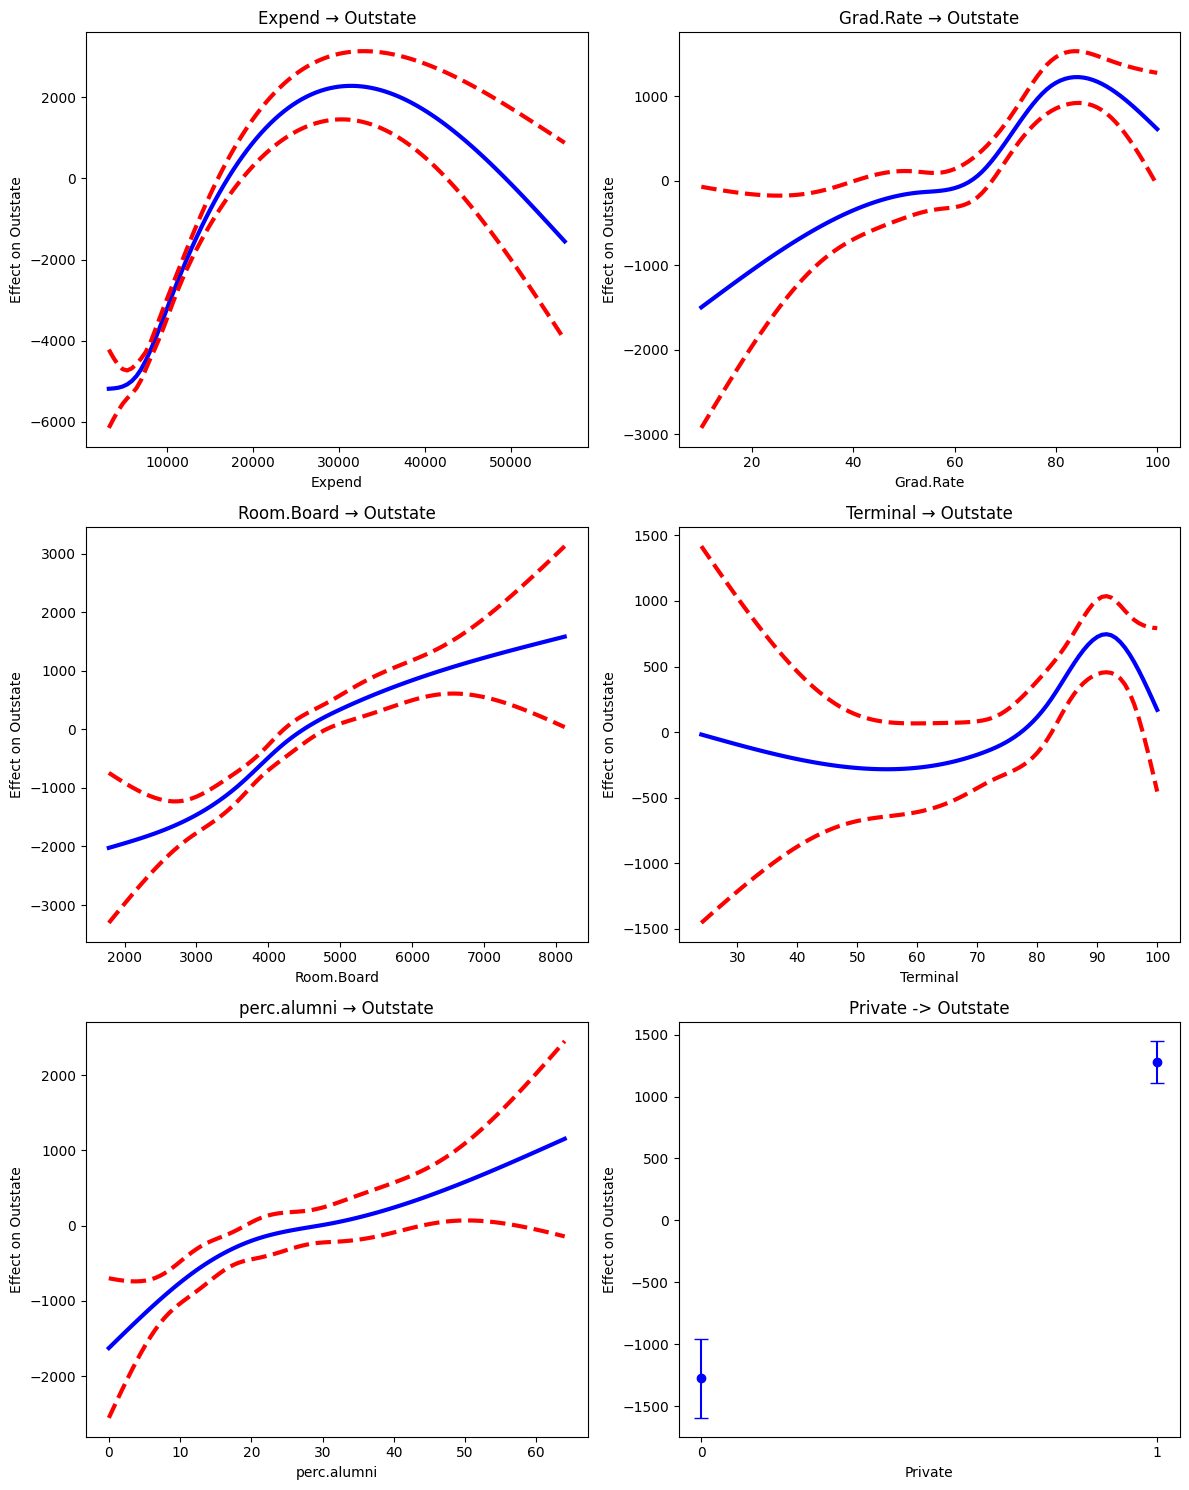

In [80]:
smooth_vars = ["Expend", "Grad.Rate", "Room.Board", "Terminal", "perc.alumni"]
linear_vars = ["Private"]

all_vars = [(v, False) for v in smooth_vars] + [(v, True) for v in linear_vars]
n_vars = len(all_vars)
n_cols = 2
n_rows = (n_vars + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5*n_rows))
axes = axes.flatten()

for i, (var, is_cat) in enumerate(all_vars):
    partial_effect(
        df=college,
        target="Outstate",
        smooth_vars=smooth_vars,
        linear_vars=linear_vars,
        study_var=var,
        is_categorical=is_cat,
        df_spline=4,
        ax=axes[i]
    )

# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()


- **Expend -> Outstate**

We see a strong nonlinear effect of instructional expenditure per student on out-of-state tuition. At very low expenditures (< \$10k), tuition is relatively depressed. As expenditures rise to around \$25k–30k, there is a steep increase in tuition — institutions that spend more per student tend to charge much higher tuition. Interestingly, after around \$30k–35k, the marginal effect flattens and eventually turns negative, suggesting diminishing returns. At very high expenditure levels, many institutions—often elite private colleges—can rely on alternative funding sources such as endowments, donations, or financial aid, reducing the need to raise tuition further.

- **Grad.Rate -> Outstate**

The initial increase in out-of-state tuition with rising graduation rates likely reflects that colleges with higher graduation rates are often perceived as providing better quality education or stronger student outcomes, allowing them to charge more. However, beyond a graduation rate of around 80%, the sharp decline in tuition may reflect a combination of factors. Schools that achieve very high graduation rates may be smaller, less selective, or public institutions that focus on affordability, which keeps tuition lower despite strong outcomes. Additionally, extremely high graduation rates can coincide with more standardized or less resource-intensive programs, limiting the need to charge higher tuition. Data sparsity at the extreme high end can also amplify this effect in the model, producing a steep downward trend. Overall, this pattern suggests that while better outcomes generally support higher tuition, very high graduation rates often occur in contexts where affordability or alternative funding mechanisms reduce the need for high out-of-state charges.

- **Room.Board -> Outstate**

Room and board costs are positively associated with out-of-state tuition. Schools with very low room/board charges tend to also have low tuition. As room and board expenses rise beyond \$3,000–4,000, tuition increases almost linearly. This makes sense, as higher overall living costs and facilities quality are often bundled with higher tuition, reflecting wealthier or urban institutions.

- **Terminal -> Outstate**

The partial effect of the percentage of faculty with terminal degrees (Terminal) on out-of-state tuition exhibits a clear nonlinear pattern. For most colleges, increases in Terminal below approximately 80% have minimal impact on tuition, suggesting that moderate levels of faculty qualification are not a distinguishing factor. Between 80% and 90%, the effect rises sharply, indicating that institutions with a very high concentration of terminally qualified faculty are able to command substantially higher tuition, likely due to perceived academic quality. Beyond 90%, the effect declines back toward zero, which is likely influenced by data sparsity at these extreme values and the smoothing inherent in the GAM. Additionally, colleges at this extreme may include smaller or public institutions where high faculty qualifications do not translate into higher tuition, reinforcing the observed drop. Overall, this pattern reflects both genuine institutional quality signals and statistical behavior in regions with few observations.

- **perc.alumni -> Outstate**

Alumni donation percentage is positively related to tuition, though the effect is nonlinear. At very low alumni giving (< 10%), tuition tends to be depressed. As alumni contribution increases beyond 20–30%, tuition rises steadily, reflecting wealthier alumni bases and institutional prestige. Interestingly, the confidence intervals widen at higher values, suggesting fewer schools with very high alumni giving, but the trend remains upward.

- **Private -> Outstate**

This categorical effect is stark. Private institutions (coded as 1) charge dramatically higher out-of-state tuition compared to public institutions (coded as 0). The difference is in the thousands of dollars, with non-overlapping error bars, making this the clearest and most significant determinant of tuition among the plotted predictors. Public institutions, by contrast, have systematically lower tuition.